# <a id='toc1_'></a>[LLM Dataset Inference Demo](#toc0_)

![LLM Dataset Inference Overview](files/llm-dataset-inference-overview.png "LLM Dataset Inference Overview")

**Table of contents**<a id='toc0_'></a>    
- [LLM Dataset Inference Demo](#toc1_)    
- [Step 0: Make Splits A and B](#toc2_)    
- [Step 1: Aggregate Features with MIAs](#toc3_)    
- [Step 2: Learn MIA Correlations](#toc4_)    
  - [Step 2.1 Remove Outliers](#toc4_1_)    
  - [Step 2.2: Learn the weights of each feature](#toc4_2_)    
- [Step 3: Dataset Inference](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook will show you how to conduct LLM Dataset Inference on your own data.

As you can see in the figure above, the process is divided into four steps:

1. Generate Features with MIAs.
2. Learn a linear classifier that assigns the importance of each feature to classify the membership of a text.
3. Perform Dataset Inference on your Data
    - a. Generate MIA features
    - b. Run the linear classifier on those MIA features
    - c. Conduct statistical tests on the ouputs of the linear classifier to determine whether there is a significance difference between them. 

In [1]:
from utils import prepare_model
from metrics import aggregate_metrics
from datasets import load_dataset

In [2]:
# model_name = "EleutherAI/pythia-410m-deduped"
# model_name = "EleutherAI/pythia-2.8b"
model_name = "EleutherAI/pythia-6.9b"
# model_name = "EleutherAI/pythia-12b"
cache_dir = "/tmp"

In [3]:
# quantization options: None, fp16, 8bit (needs accelerate)
llm, tokenizer = prepare_model(model_name, cache_dir=cache_dir, quant="fp16")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded


# <a id='toc2_'></a>[Step 0: Make Splits A and B](#toc0_)

Splits A from members and non-members are used to trained the NN.

Splits B from members and non-members are used to perform Dataset Inference (DI)

In [4]:
from datasets import load_dataset

ds = load_dataset("haritzpuerto/the_pile_arxiv_50k_sample")

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'meta'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'meta'],
        num_rows: 2434
    })
    test: Dataset({
        features: ['text', 'meta'],
        num_rows: 2407
    })
})

In [6]:
A_members = ds['train'].select(range(0, 1000))
A_nonmembers = ds['validation'].select(range(1000))

B_members = ds['train'].select(range(1000, 2000))
B_nonmembers = ds['validation'].select(range(1000, 2000))

# <a id='toc3_'></a>[Step 1: Aggregate Features with MIAs](#toc0_)

In [7]:
metric_list = ["k_min_probs", "ppl", "zlib_ratio", "k_max_probs"]

In [8]:
batch_size = 2

In [9]:
A_members_metrics = aggregate_metrics(llm, tokenizer, A_members, metric_list, None, batch_size=batch_size)

100%|██████████| 500/500 [09:40<00:00,  1.16s/it]


In [10]:
len(A_members_metrics['ppl'])

1000

In [11]:
A_nonmembers_metrics = aggregate_metrics(llm, tokenizer, A_nonmembers, metric_list, None, batch_size=batch_size)

100%|██████████| 500/500 [09:39<00:00,  1.16s/it]


# <a id='toc4_'></a>[Step 2: Learn MIA Correlations](#toc0_)

In this stage, we train a linear regressor to learn the importance of weights for different MIA attacks to use for the final dataset inference procedure. 

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, chi2, norm
import torch
import torch.nn as nn
from tqdm import tqdm
from selected_features import feature_list

In [13]:
def split_train_val(metrics):
    keys = list(metrics.keys())
    num_elements = len(metrics[keys[0]])
    print (f"Using {num_elements} elements")
    # select a random subset of val_metrics (50% of ids)
    ids_train = np.random.choice(num_elements, num_elements//2, replace=False)
    ids_val = np.array([i for i in range(num_elements) if i not in ids_train])
    new_metrics_train = {}
    new_metrics_val = {}
    for key in keys:
        new_metrics_train[key] = np.array(metrics[key])[ids_train]
        new_metrics_val[key] = np.array(metrics[key])[ids_val]
    return new_metrics_train, new_metrics_val

def remove_outliers(metrics, remove_frac=0.05, outliers = "zero"):
    # Sort the array to work with ordered data
    sorted_ids = np.argsort(metrics)
    
    # Calculate the number of elements to remove from each side
    total_elements = len(metrics)
    elements_to_remove_each_side = int(total_elements * remove_frac / 2) 
    
    # Ensure we're not attempting to remove more elements than are present
    if elements_to_remove_each_side * 2 > total_elements:
        raise ValueError("remove_frac is too large, resulting in no elements left.")
    
    # Change the removed metrics to 0.
    lowest_ids = sorted_ids[:elements_to_remove_each_side]
    highest_ids = sorted_ids[-elements_to_remove_each_side:]
    all_ids = np.concatenate((lowest_ids, highest_ids))

    # import pdb; pdb.set_trace()
    
    trimmed_metrics = np.copy(metrics)
    
    if outliers == "zero":
        trimmed_metrics[all_ids] = 0
    elif outliers == "mean" or outliers == "mean+p-value":
        trimmed_metrics[all_ids] = np.mean(trimmed_metrics)
    elif outliers == "clip":
        highest_val_permissible = trimmed_metrics[highest_ids[0]]
        lowest_val_permissible = trimmed_metrics[lowest_ids[-1]]
        trimmed_metrics[highest_ids] =  highest_val_permissible
        trimmed_metrics[lowest_ids] =   lowest_val_permissible
    elif outliers == "randomize":
        #this will randomize the order of metrics
        trimmed_metrics = np.delete(trimmed_metrics, all_ids)
    else:
        assert outliers in ["keep", "p-value"]
        pass
        
    
    return trimmed_metrics

def normalize_and_stack(train_metrics, val_metrics, normalize="train"):
    '''
    excpects an input list of list of metrics
    normalize val with corre
    '''
    new_train_metrics = []
    new_val_metrics = []
    for (tm, vm) in zip(train_metrics, val_metrics):
        if normalize == "combined":
            combined_m = np.concatenate((tm, vm))
            mean_tm = np.mean(combined_m)
            std_tm = np.std(combined_m)
        else:
            mean_tm = np.mean(tm)
            std_tm = np.std(tm)
        
        if normalize == "no":
            normalized_vm = vm
            normalized_tm = tm
        else:
            #normalization should be done with respect to the train set statistics
            normalized_vm = (vm - mean_tm) / std_tm
            normalized_tm = (tm - mean_tm) / std_tm
        
        new_train_metrics.append(normalized_tm)
        new_val_metrics.append(normalized_vm)

    train_metrics = np.stack(new_train_metrics, axis=1)
    val_metrics = np.stack(new_val_metrics, axis=1)
    return train_metrics, val_metrics

## <a id='toc4_1_'></a>[Step 2.1 Remove Outliers](#toc0_)

Across each MIA feature value, we first modify the top 5% outliers by changing their values to the mean of the distribution. This step is crucial to prevent issues in Step 3, where the model might learn skewed correlations due to a few outlier samples. 

In [14]:
def prepare_metrics(members_metrics, nonmembers_metrics, outliers="clip", return_tensors=False):
    keys = list(members_metrics.keys())
    np_members_metrics = []
    np_nonmembers_metrics = []
    for key in keys:
        members_metric_key = np.array(members_metrics[key])
        nonmembers_metric_key = np.array(nonmembers_metrics[key])
        
        if outliers is not None:
            # remove the top 2.5% and bottom 2.5% of the data
            members_metric_key = remove_outliers(members_metric_key, remove_frac = 0.05, outliers = outliers)
            nonmembers_metric_key = remove_outliers(nonmembers_metric_key, remove_frac = 0.05, outliers = outliers)

        np_members_metrics.append(members_metric_key)
        np_nonmembers_metrics.append(nonmembers_metric_key)

    # concatenate the train and val metrics by stacking them
    np_members_metrics, np_nonmembers_metrics = normalize_and_stack(np_members_metrics, np_nonmembers_metrics)
    if return_tensors:
        np_members_metrics = torch.tensor(np_members_metrics, dtype=torch.float32)
        np_nonmembers_metrics = torch.tensor(np_nonmembers_metrics, dtype=torch.float32)

    return np_members_metrics, np_nonmembers_metrics

In [15]:
train_metrics, val_metrics  = prepare_metrics(A_members_metrics, A_nonmembers_metrics, outliers="clip")

print(train_metrics.shape)
print(val_metrics.shape)

(1000, 16)
(999, 16)


In [16]:
# aux functions about MIA classifier

def get_dataset_splits(_train_metrics, _val_metrics, num_samples):
    # get the train and val sets
    for_train_train_metrics = _train_metrics[:num_samples]
    for_train_val_metrics = _val_metrics[:num_samples]
    for_val_train_metrics = _train_metrics[num_samples:]
    for_val_val_metrics = _val_metrics[num_samples:]


    # create the train and val sets
    train_x = np.concatenate((for_train_train_metrics, for_train_val_metrics), axis=0)
    train_y = np.concatenate((-1*np.zeros(for_train_train_metrics.shape[0]), np.ones(for_train_val_metrics.shape[0])))
    val_x = np.concatenate((for_val_train_metrics, for_val_val_metrics), axis=0)
    val_y = np.concatenate((-1*np.zeros(for_val_train_metrics.shape[0]), np.ones(for_val_val_metrics.shape[0])))
    
    # return tensors
    train_x = torch.tensor(train_x, dtype=torch.float32)
    train_y = torch.tensor(train_y, dtype=torch.float32)
    val_x = torch.tensor(val_x, dtype=torch.float32)
    val_y = torch.tensor(val_y, dtype=torch.float32)
    
    return (train_x, train_y), (val_x, val_y)

def train_model(inputs, y, num_epochs=10000):
    num_features = inputs.shape[1]
    model = get_model(num_features)
        
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Convert y to float tensor for BCEWithLogitsLoss
    y_float = y.float()

    with tqdm(range(num_epochs)) as pbar:
        for epoch in pbar:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()  # Squeeze the output to remove singleton dimension
            loss = criterion(outputs, y_float)
            loss.backward()
            optimizer.step()
            pbar.set_description('loss {}'.format(loss.item()))
    return model

def get_model(num_features, linear = True):
    if linear:
        model = nn.Linear(num_features, 1)
    else:
        model = nn.Sequential(
            nn.Linear(num_features, 10),
            nn.ReLU(),
            nn.Linear(10, 1)  # Single output neuron
        )
    return model

def get_predictions(model, val, y):
    with torch.no_grad():
        preds = model(val).detach().squeeze()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(preds, y.float())
    return preds.numpy(), loss.item()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, val, y):
    # get auc and plot roc curve
    from sklearn.metrics import roc_auc_score
    preds, _ = get_predictions(model, val, y)
    auc_score = roc_auc_score(y, preds)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, preds)
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## <a id='toc4_2_'></a>[Step 2.2: Learn the weights of each feature](#toc0_)

We then pass the data through a linear regression model to learn weights for each feature.


⚠️ **Members are classified as 0, while non-members as 1.**

In [17]:
# aux functions about p-values
list_number_samples = [2, 5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

def get_p_value_list(heldout_train, heldout_val, list_number_samples):
    # list_number_samples is used to see how the p-values changes across different number of samples
    p_value_list = []
    for num_samples in list_number_samples:
        heldout_train_curr = heldout_train[:num_samples]
        heldout_val_curr = heldout_val[:num_samples]
        t, p_value = ttest_ind(heldout_train_curr, heldout_val_curr, alternative='less')
        p_value_list.append(p_value)
    return p_value_list
    
    

def split_train_val(metrics):
    keys = list(metrics.keys())
    num_elements = len(metrics[keys[0]])
    print (f"Using {num_elements} elements")
    # select a random subset of val_metrics (50% of ids)
    ids_train = np.random.choice(num_elements, num_elements//2, replace=False)
    ids_val = np.array([i for i in range(num_elements) if i not in ids_train])
    new_metrics_train = {}
    new_metrics_val = {}
    for key in keys:
        new_metrics_train[key] = np.array(metrics[key])[ids_train]
        new_metrics_val[key] = np.array(metrics[key])[ids_val]
    return new_metrics_train, new_metrics_val

In [18]:
num_samples = 250 # How many samples to use for training and validation?

np.random.shuffle(train_metrics)
np.random.shuffle(val_metrics)

# train a model by creating a train set and a held out set
(train_x, train_y), (val_x, val_y) = get_dataset_splits(train_metrics, val_metrics, num_samples)

model = train_model(train_x, train_y, num_epochs = 1000)

# using the model weights, get importance of each feature, and save to csv
weights = model.weight.data.squeeze().tolist() 
features = list(A_members_metrics.keys())
feature_importance = {feature: weight for feature, weight in zip(features, weights)}
df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

loss 0.6681151986122131: 100%|██████████| 1000/1000 [00:01<00:00, 659.06it/s]


In [19]:
df

,Feature,Importance
0,ppl,0.187106
1,k_min_probs_0.05,0.051939
2,k_min_probs_0.1,-0.513615
3,k_min_probs_0.2,1.180070
4,k_min_probs_0.3,-1.855523
5,k_min_probs_0.4,1.458794
6,k_min_probs_0.5,-0.619759
7,k_min_probs_0.6,0.117170
8,k_max_probs_0.05,-0.679361
9,k_max_probs_0.1,1.334020


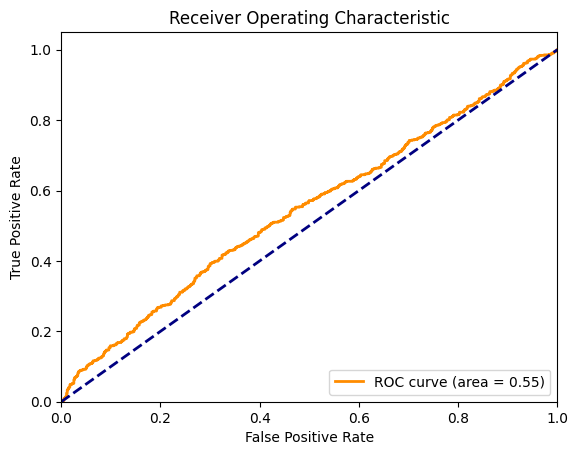

In [20]:
auc = plot_roc_curve(model, val_x, val_y)

# <a id='toc5_'></a>[Step 3: Dataset Inference](#toc0_)

⚠️ **Remember: Members are classified as 0, while non-members as 1.**

In [21]:
B_members_metrics = aggregate_metrics(llm, tokenizer, B_members, metric_list, None, batch_size=batch_size)
B_nonmembers_metrics = aggregate_metrics(llm, tokenizer, B_nonmembers, metric_list, None, batch_size=batch_size)

100%|██████████| 500/500 [09:40<00:00,  1.16s/it]


In [22]:
B_members_metrics_tensor, B_nonmembers_metrics_ternsor = prepare_metrics(B_members_metrics, B_nonmembers_metrics, outliers=None, return_tensors=True)
B_members_preds, _ = get_predictions(model, B_members_metrics_tensor, torch.tensor([0]*B_members_metrics_tensor.shape[0]))
B_nonmembers_preds, _ = get_predictions(model, B_nonmembers_metrics_ternsor, torch.tensor([1]*B_nonmembers_metrics_ternsor.shape[0]))

p_value_list = get_p_value_list(B_members_preds, B_nonmembers_preds, list_number_samples=[1000])

print(f"The null hypothesis is that the B_members scores are larger or equal than B_nonmembers.\nThe alternative hypothesis is that B_members (0) are lower than B_nonmembers (1) . The p-value is {p_value_list[-1]}")

The null hypothesis is that the B_members scores are larger or equal than B_nonmembers.
The alternative hypothesis is that B_members (0) are lower than B_nonmembers (1) . The p-value is 0.00331255002904568
